In [28]:
import numpy as np
from scipy.stats import norm
from scipy.stats import pareto
from math import ceil
import scipy.optimize as opt
import matplotlib.pyplot as plt

def datos_punto1(n: int, d: int, mu0 = None, mu1 = None, Sigma = None):
    """
    Args:
        n: number of data points per category.
        d: number of dimensions.
        mu0 (d-size numpy array): the mean of category 0.
        If None, then it's randomly generated. 
        mu1 (d-size numpy array): the mean of category 1.
        If None, then it's randomly generated.
        Sigma(d*d numpy array): the covariance matrix.
        If None, then it's randomly generated. 
    Returns:
        datos0: points that correspond to category 0.
        datos1: points that correspond to category 1.
        mu0: the mean of category 0.
        mu1: the mean of category 1.
        Sigma: the covariance matrix.
    """
    if Sigma is None:
        S = np.random.random(size=d*d).reshape((d,d))
        D, U = np.linalg.eig(S + S.T)
        D =  np.diagflat(np.random.random(d) * 7 * d ** 0.5)
        A = np.dot(U,np.sqrt(D))
        Sigma = np.dot(A,A.T)
    else:
        D, U = np.linalg.eig(Sigma)
        D = np.diagflat(D)
        A = np.dot(U,np.sqrt(D))
    if mu0 == None:
        mu0 = (np.random.random(size=d) * 10).reshape((d,1))
    if mu1 == None:
        mu1 = (np.random.random(size=d) * 10).reshape((d,1))
    datos0 = norm.rvs(size=n*d).reshape((d,n))
    datos0 = np.dot(A,datos0) + mu0
    datos1 = norm.rvs(size=n*d).reshape((d,n))
    datos1 = np.dot(A,datos1) + mu1
    return datos0, datos1, mu0, mu1, Sigma

def error_empirico(w0, w, x1, x2):
    error = 0
    condiciones1 = np.dot(w.T, x1)
    condiciones2 = np.dot(w.T, x2)

    error += np.sum(condiciones1 + w0 < 0)
    error += np.sum(condiciones2 + w0 > 0)
    return error

def disc_lin_gaussian(x1, x2, d, n, MCD = False):
    x1 = np.matrix(x1)
    x2= np.matrix(x2)
    if MCD == False:
        #Medias muestrales
        m1, m2 = np.mean(x1, axis = 1), np.mean(x2, axis = 1)
        #Matrices de covarianza muestrales
        S1, S2 = np.matrix(np.zeros((d,d))), np.matrix(np.zeros((d,d)))
        for j in range(n):
            S1 += np.dot((x1[:,j] - m1), (x1[:,j] - m1).T)
            S2 += np.dot((x2[:,j] - m2), (x2[:,j] - m2).T)
        C = (S1 + S2)/(2*n)
        #Vector sobre el cual se proyecta
        w = np.dot(np.linalg.inv(C), (m1-m2))
        #threshold se calcula teniendo en cuenta el duda
        p0 = 0.5*(m1-m2)
        w0 = -np.dot(w.T, p0)
        
        #implementar MCD algorithm
    return w, w0

def disc_lin_fisher(x1, x2, d, n, MCD = False):
    x1 = np.matrix(x1)
    x2 = np.matrix(x2)
    
    if MCD == False:
        #Medias muestrales
        m1, m2 = np.mean(x1, axis = 1), np.mean(x2, axis = 1)
        #Matrices de covarianza muestrales
        S1, S2 = np.matrix(np.zeros((d,d))), np.matrix(np.zeros((d,d)))
        for j in range(n):
            S1 += np.dot((x1[:,j] - m1), (x1[:,j] - m1).T)
            S2 += np.dot((x2[:,j] - m2), (x2[:,j] - m2).T)
        Sw = S1 + S2
        #Vector sobre el cual se proyecta
        w = np.linalg.inv(Sw)
        w = np.dot(w, (m1-m2))
        w = w/np.linalg.norm(w)
        #threshold se calculará minimizando el eror empirico.
        """
        Este se calcula a fuerza bruta, considerando todos los resultados de la operación w0:= -w.Tx, donde x está en cualquiera de estas muestras.
        Es decir, se obtrandrán 2*n w0, sin embargo, para que el clasificador puede tener la opción de elegir si ese x está en una de las
        dos clases, lo que se hará es perturbar elw0 que se obtuvo y así obtener w0+:= -w.Tx + (w.Tx)*e-3 y w0-:= -w.T -(w.Tx)*e-3. Esto permite perturbar
        un poco ese w0 que se obtiene y así tener las dos opciones de clasificar ese dato x en cualquiera de las dos clases y ver cual de ellos minimiza 
        el error empírico de clasificación.

        finalmente, con esa lista de 4*n w0's, se elige el que minimice la función a fuerza bruta.
        """
        #posibles w0 y sus errores.
        w0 = np.matrix(np.zeros((2,4*n)))
        for j in range(n):
            w0[0,j] = -np.dot(w.T, x1[:,j]) + (np.dot(w.T, x1[:,j]))*1E-2
            w0[0,j+n] = -np.dot(w.T, x1[:,j]) - (np.dot(w.T, x1[:,j]))*1E-2
            w0[0,j+2*n] = -np.dot(w.T, x2[:,j]) + (np.dot(w.T, x2[:,j]))*1E-2
            w0[0,j+3*n]= -np.dot(w.T, x2[:,j]) - (np.dot(w.T, x2[:,j]))*1E-2   

            w0[1,j] = error_empirico(w0[0,j], w, x1, x2)
            w0[1,j+n] = error_empirico(w0[0,j +n], w, x1, x2)
            w0[1,j+2*n] = error_empirico(w0[0,j+2*n], w, x1, x2)
            w0[1,j+3*n] = error_empirico(w0[0,j+3*n], w, x1, x2)
        mejor_error_inidice = np.argmin(np.array(w0)[1])
        mejor_w0= w0[0, mejor_error_inidice]
        
        
    return w, mejor_w0
    

In [31]:
#Dimension 2
n, d, mu0, mu1, Sigma = 1000, 2, -6, 7, np.array([[10,2],[2,13]])
datos0, datos1, mu0, mu1, Sigma = datos_punto1(n, d, mu0, mu1, Sigma)

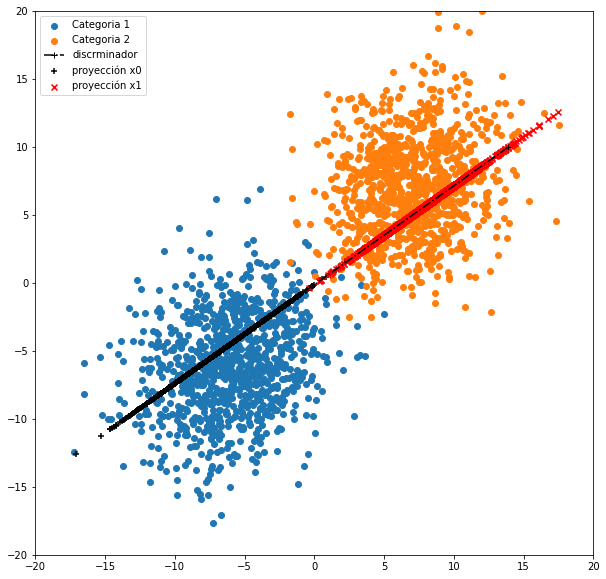

In [34]:
#Discriminador Lineal Gaussiano
###
#Discriminador lineal gaussiano (ver aclaratoria abajo). Evaluar la cota del error
#de clasificaci´on de Chernoff en uno de los conjuntos de datos de cada dimensi´on y
#comparar con el error emp´ırico del clasificad
###
datos0 = np.array(datos0)
datos1 = np.array(datos1)


#Sin usar MCD
plt.figure(figsize=(10,10))
x0,y0 = datos0[0], datos0[1]
x1,y1 = datos1[0], datos1[1]
plt.scatter(x0,y0, label="Categoria 1")
plt.scatter(x1,y1, label="Categoria 2")
xmin = np.min([np.min(x0), np.min(x1)])
xmax = np.max([np.max(x0), np.max(x1)])

ymin = np.min([np.min(y0), np.min(y1)])
ymax = np.max([np.max(y0), np.max(y1)])


#obtenemos un punto que pasa por la recta
p0 = np.matrix([[0],[-w0/w[1,0]]])

t = np.matrix(np.linspace(xmin, xmax, 2))
puntos_recta = np.array(np.dot(w,t) + p0)

datos0 = np.matrix(datos0)
datos1 = np.matrix(datos1)

datos0proy = np.array(np.dot(w,np.dot(w.T,datos0 - p0)/(np.dot(w.T, w)))+p0) 
datos1proy = np.array(np.dot(w,np.dot(w.T,datos1 - p0)/(np.dot(w.T, w)))+p0)  


plt.plot(puntos_recta[0],puntos_recta[1], label="discrminador", color="black", marker="+", ls="-.")
plt.xlim(-20, 20)
plt.ylim(-20, 20)

plt.scatter(datos0proy[0],datos0proy[1], label="proyección x0", color="black", marker="+")
plt.scatter(datos1proy[0],datos1proy[1], label="proyección x1", color="red", marker="x")
plt.legend()


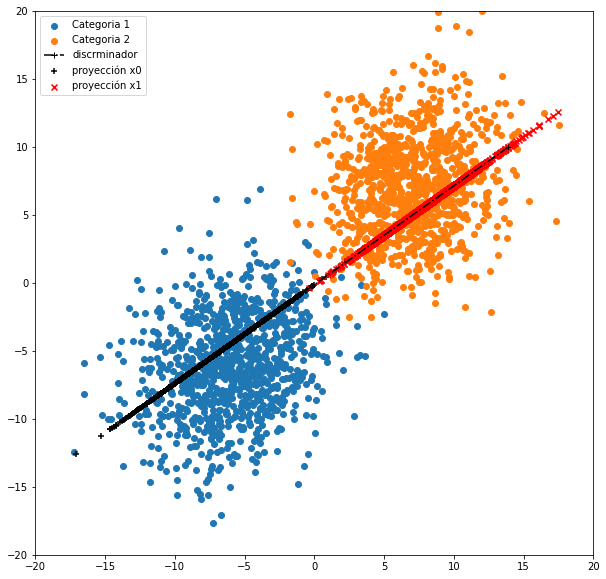

In [35]:
"""
2.3 Discriminador lineal de Fisher, eligiendo el punto de corte por minimizaci´on de
error emp´ırico. (HECHOOOOOOOOOOOOOOOOO)
"""

datos0 = np.array(datos0)
datos1 = np.array(datos1)

#Sin usar MCD
w, w0 = disc_lin_fisher(np.matrix(datos0), np.matrix(datos1), d,n, MCD = False)

plt.figure(figsize=(10,10))
x0,y0 = datos0[0], datos0[1]
x1,y1 = datos1[0], datos1[1]
plt.scatter(x0,y0, label="Categoria 1")
plt.scatter(x1,y1, label="Categoria 2")
xmin = np.min([np.min(x0), np.min(x1)])
xmax = np.max([np.max(x0), np.max(x1)])

ymin = np.min([np.min(y0), np.min(y1)])
ymax = np.max([np.max(y0), np.max(y1)])


#obtenemos un punto que pasa por la recta
p0 = np.matrix([[0],[-w0/w[1,0]]])

t = np.matrix(np.linspace(xmin, xmax, 2))
puntos_recta = np.array(np.dot(w,t) + p0)

datos0 = np.matrix(datos0)
datos1 = np.matrix(datos1)

datos0proy = np.array(np.dot(w,np.dot(w.T,datos0 - p0)/(np.dot(w.T, w)))+p0) 
datos1proy = np.array(np.dot(w,np.dot(w.T,datos1 - p0)/(np.dot(w.T, w)))+p0)  


plt.plot(puntos_recta[0],puntos_recta[1], label="discrminador", color="black", marker="+", ls="-.")
plt.xlim(-20, 20)
plt.ylim(-20, 20)

plt.scatter(datos0proy[0],datos0proy[1], label="proyección x0", color="black", marker="+")
plt.scatter(datos1proy[0],datos1proy[1], label="proyección x1", color="red", marker="x")
plt.legend()